In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,poisson_glm
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix
from experiments import training_loop
from plotting_funcs import plot_losses, plot_frontier

import tensorflow as tf
import numpy as np

2024-04-29 13:59:21.449042: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:59:21.509081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 13:59:21.509115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 13:59:21.510356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 13:59:21.519602: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed=360
num_components=4
learning_rate = 0.005
epochs=1250
outdir = '/cluster/home/kheuto01/testdir'
penalty = 0
threshold = 0.45
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 50
# total timepoints
T= 500

In [3]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed)

input_shape = (H,S)

negative_bpr_K = get_bpr_loss_func(K)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0: 72.37085723876953
1: 67.09626007080078
2: 61.983402252197266
3: 57.062164306640625
4: 52.38310241699219
5: 48.058616638183594
6: 44.2341423034668
7: 40.93093490600586
8: 38.136234283447266
9: 35.941226959228516
10: 34.284297943115234
11: 32.976417541503906
12: 31.869028091430664
13: 30.9059

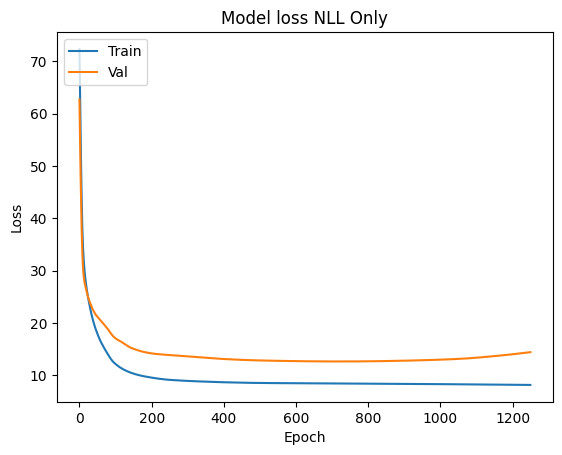

<Figure size 640x480 with 0 Axes>

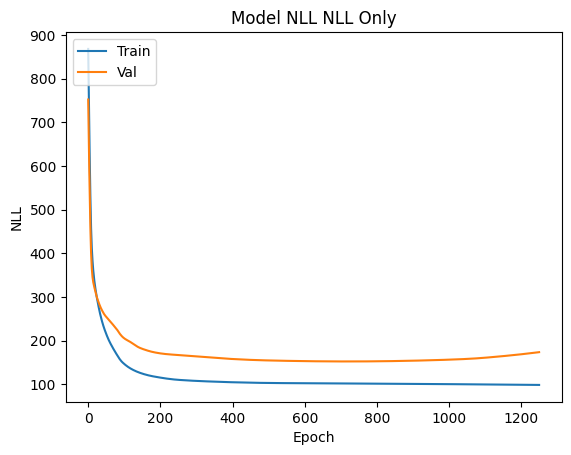

<Figure size 640x480 with 0 Axes>

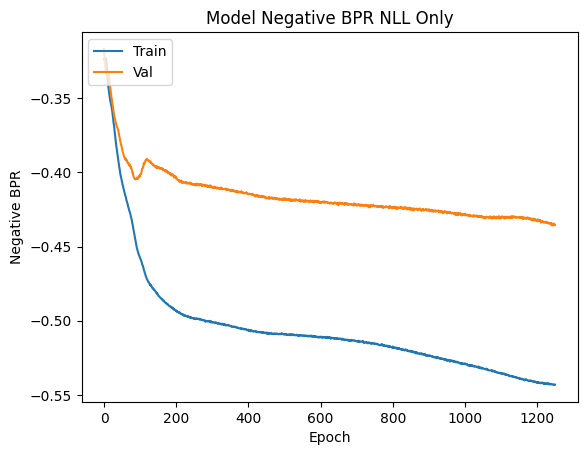

<Figure size 640x480 with 0 Axes>

In [4]:
mix_model_nll, _  = mixture_poissons(poisson_glm, input_shape, num_components=num_components)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
losses_nll = training_loop(mix_model_nll, mixture_poi_loss, optimizer, epochs,
                            train_dataset, val_dataset, negative_bpr_K,
                        verbose=True)
plot_losses(losses_nll, title_add='NLL Only', save_dir=outdir, file_add='nll')

In [93]:
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
        y_preds = mix_model_nll(x_batch_train, training=True)
        loss_value = mixture_poi_loss(y_batch_train, y_preds)

    grads = tape.gradient(loss_value, mix_model_nll.trainable_weights)

    optimizer.apply_gradients(zip(grads, mix_model_nll.trainable_weights))

    print(tf.reduce_mean(loss_value))

tf.Tensor(8.179615, shape=(), dtype=float32)


In [94]:
y_preds = mix_model_nll(train_X_THS)
loss = mixture_poi_loss(train_y_TS, y_preds)
loss = tf.reduce_mean(loss)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=8.178946>

In [83]:
train_X_THS, train_y_TS = np.concatenate([x for x, y in train_dataset], axis=0), np.concatenate([y for x, y in train_dataset], axis=0)
val_X_THS, val_y_TS = np.concatenate([x for x, y in val_dataset], axis=0), np.concatenate([y for x, y in val_dataset], axis=0)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)

In [84]:
train_X_THS.shape

(300, 50, 12)

In [72]:
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    print(x_batch_train[0,0,:])

tf.Tensor([ 7.  7.  7.  7. 10. 10.  0. 10.  0.  0.  0.  0.], shape=(12,), dtype=float32)


In [77]:
[x for x, y in train_dataset][0]

<tf.Tensor: shape=(300, 50, 12), dtype=float32, numpy=
array([[[  7.,   7.,   7., ...,   0.,   0., 100.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        ...,
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ..., 100.,   0.,   0.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.]],

       [[  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        ...,
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,   1.,   1.,   1.]],

       [[  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0., 100.,   0.],
        ...,
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  7.,   7.,   7., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,   1

In [78]:
T

500